# Imports

In [32]:
import os
import sys
sys.path.append('/home/rcendre/classification')

import itertools
import pandas
import webbrowser
from pathlib import Path
import matplotlib.pyplot as plt
from misvm import SIL, MISVM
from numpy import array, logspace
from scipy.stats import randint,uniform
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import davies_bouldin_score
from toolbox.classification.common import Data, Folds, IO, Tools
from toolbox.classification.parameters import Dermatology, Settings
from toolbox.models.models import CustomMIL, MultimodalClassifier
from toolbox.models.builtin import Applications
from toolbox.IO import dermatology
from sklearn.metrics import f1_score
from toolbox.transforms.common import PredictorTransform, FlattenTransform, LinearTransform
from toolbox.transforms.labels import OrderedEncoder
from toolbox.transforms.images import DistributionImageTransform, DWTImageTransform, FourierImageTransform, HaralickImageTransform, SpatialImageTransform
from toolbox.views.common import Views, ViewsTools
from toolbox.views.images import ImagesViews
import warnings
warnings.filterwarnings('ignore') 

# Parameters

In [33]:
# Advanced parameters
data_type='Full'
prefix = 'Cumulative'
validation = 10
settings = Settings.get_default_dermatology()

# Photography

In [34]:
p_inputs = IO.load('Photography.pickle')

In [35]:
p_inputs['Extractor'] = p_inputs['ResNetAvg']

# Pipeline
model = Pipeline([('scale', MinMaxScaler()), ('clf', LinearSVC(class_weight='balanced'))])
model_params = {'clf__C': logspace(-2, 3, 6).tolist()}

In [36]:
low_folds = Tools.generate_folds(([1, 2, 3, 4, 5, 6, 7, 8], [9]), validation)
Tools.evaluate(p_inputs, {'datum': 'Extractor', 'label_encode': 'LesionEncode'}, model, 'Prediction', folds=low_folds, distribution=model_params) 

In [37]:
from IPython.display import HTML
from IPython.display import display

diagnosis_encoder = OrderedEncoder().fit(['Benign', 'Malignant'])

# ROC Curve
ViewsTools.plot_size((8,8))     

name = f'Prediction'
# Label
display(HTML(ViewsTools.dataframe_renderer([Views.report(p_inputs, {'label_encode': 'LesionEncode', 'eval': name}, diagnosis_encoder)],
                                                                    title=[f'Photography'])))

,precision,recall,f1-score,support
Benign,0.53±0.16,0.57±0.19,0.55±0.16,86.00±2.29
Malignant,0.72±0.13,0.68±0.09,0.70±0.10,138.00±2.36
accuracy,0.64±0.10,0.64±0.10,0.64±0.10,0.64±0.10
macro avg,0.62±0.11,0.63±0.10,0.62±0.11,224.00±0.49
weighted avg,0.64±0.11,0.64±0.10,0.64±0.10,224.00±0.49


# Dermoscopy

In [38]:
d_inputs = IO.load('Dermoscopy.pickle')
d_inputs['Extractor'] = d_inputs['ResNetAvg']

In [39]:
dp_inputs = IO.load('Photography.pickle')
dp_inputs['Extractor'] = dp_inputs['ResNetAvg']
d_inputs = pandas.concat([dp_inputs, d_inputs], axis=0)

In [40]:
all_image = [True] * len(d_inputs.index)
single_image = d_inputs['Modality'] == 'Dermoscopy'
Data.build_bags(d_inputs, single_image, 'ID_Lesion', all_image, 'ID_Lesion', 'Extractor')
d_inputs = d_inputs[single_image].reset_index()
Tools.transform(d_inputs, {'datum': 'Extractor'}, FlattenTransform(), 'Flat')

In [41]:
low_folds = Tools.generate_folds(([1, 2, 3, 4, 5, 6, 7, 8], [9]), validation)

# Pipeline
model = Pipeline([('scale', MinMaxScaler()), ('clf', LinearSVC(class_weight='balanced'))])
model_params = {'clf__C': logspace(-2, 3, 6).tolist()}

Tools.evaluate(d_inputs, {'datum': 'Flat', 'label_encode': 'LesionEncode'}, model, 'Prediction', folds=low_folds, distribution=model_params) 

In [42]:
from IPython.display import HTML
from IPython.display import display

diagnosis_encoder = OrderedEncoder().fit(['Benign', 'Malignant'])

# ROC Curve
ViewsTools.plot_size((8,8))     

name = f'Prediction'
# Label
display(HTML(ViewsTools.dataframe_renderer([Views.report(d_inputs, {'label_encode': 'LesionEncode', 'eval': name}, diagnosis_encoder)],
                                                                    title=[f'Dermoscopy'])))

,precision,recall,f1-score,support
Benign,0.58±0.20,0.57±0.20,0.58±0.19,86.00±2.29
Malignant,0.74±0.14,0.75±0.12,0.74±0.12,138.00±2.36
accuracy,0.68±0.13,0.68±0.13,0.68±0.13,0.68±0.13
macro avg,0.66±0.14,0.66±0.13,0.66±0.14,224.00±0.49
weighted avg,0.68±0.13,0.68±0.13,0.68±0.13,224.00±0.49


# Microscopy

In [43]:
m_inputs = IO.load('Microscopy.pickle')

## Merge

In [44]:
extractor = 'ResNetAvg'
low_folds = Tools.generate_folds(([1, 2, 3, 4, 5, 6, 7, 8], [9]), validation)

In [45]:
all_image = [True] * len(m_inputs.index)
single_image = m_inputs['ID_Image'] == '0M'
Data.build_bags(m_inputs, single_image, 'ID_Lesion', all_image, 'ID_Lesion', extractor)
m_inputs = m_inputs[single_image].reset_index()

In [46]:
Tools.transform(m_inputs, {'datum': extractor}, LinearTransform(method='average'), 'Avg')
Tools.transform(m_inputs, {'datum': extractor}, LinearTransform(method='max'), 'Max')
Tools.transform(m_inputs, {'datum': extractor}, LinearTransform(method=4), 'Norm4')
Tools.transform(m_inputs, {'datum': extractor}, LinearTransform(method=6), 'Norm6')
Tools.transform(m_inputs, {'datum': extractor}, LinearTransform(method=8), 'Norm8')

In [47]:
# Pipeline
model = Pipeline([('scale', MinMaxScaler()), ('clf', LinearSVC(class_weight='balanced'))])
model_params = {'clf__C': logspace(-2, 3, 6).tolist()}

Tools.fit_predict(m_inputs, {'datum': 'Avg', 'label_encode': 'LesionEncode'}, model, 'PredictionAvg', folds=low_folds, distribution=model_params)
Tools.fit_predict(m_inputs, {'datum': 'Max', 'label_encode': 'LesionEncode'}, model, 'PredictionMax', folds=low_folds, distribution=model_params)
Tools.fit_predict(m_inputs, {'datum': 'Norm4', 'label_encode': 'LesionEncode'}, model, 'PredictionNorm4', folds=low_folds, distribution=model_params)
Tools.fit_predict(m_inputs, {'datum': 'Norm6', 'label_encode': 'LesionEncode'}, model, 'PredictionNorm6', folds=low_folds, distribution=model_params)
Tools.fit_predict(m_inputs, {'datum': 'Norm8', 'label_encode': 'LesionEncode'}, model, 'PredictionNorm8', folds=low_folds, distribution=model_params)

In [48]:
from IPython.display import HTML
from IPython.display import display

diagnosis_encoder = OrderedEncoder().fit(['Benign', 'Malignant'])

# ROC Curve
ViewsTools.plot_size((8,8))     

name = f'PredictionAvg'
display(HTML(ViewsTools.dataframe_renderer([Views.report(m_inputs, {'label_encode': 'LesionEncode', 'eval': name}, diagnosis_encoder)],
                                                                    title=[f'Microscopy Avg'])))

name = f'PredictionMax'
display(HTML(ViewsTools.dataframe_renderer([Views.report(m_inputs, {'label_encode': 'LesionEncode', 'eval': name}, diagnosis_encoder)],
                                                                    title=[f'Microscopy Max'])))

name = f'PredictionNorm4'
display(HTML(ViewsTools.dataframe_renderer([Views.report(m_inputs, {'label_encode': 'LesionEncode', 'eval': name}, diagnosis_encoder)],
                                                                    title=[f'Microscopy Norm4'])))

name = f'PredictionNorm6'
display(HTML(ViewsTools.dataframe_renderer([Views.report(m_inputs, {'label_encode': 'LesionEncode', 'eval': name}, diagnosis_encoder)],
                                                                    title=[f'Microscopy Norm6'])))

name = f'PredictionNorm8'
display(HTML(ViewsTools.dataframe_renderer([Views.report(m_inputs, {'label_encode': 'LesionEncode', 'eval': name}, diagnosis_encoder)],
                                                                    title=[f'Microscopy Norm8'])))

,precision,recall,f1-score,support
Benign,0.81±0.19,0.81±0.17,0.81±0.16,86.00±2.29
Malignant,0.88±0.08,0.88±0.10,0.88±0.08,138.00±2.36
accuracy,0.86±0.10,0.86±0.10,0.86±0.10,0.86±0.10
macro avg,0.85±0.12,0.85±0.11,0.85±0.11,224.00±0.49
weighted avg,0.86±0.10,0.86±0.10,0.86±0.10,224.00±0.49


,precision,recall,f1-score,support
Benign,0.80±0.18,0.77±0.19,0.78±0.17,86.00±2.29
Malignant,0.86±0.11,0.88±0.09,0.87±0.09,138.00±2.36
accuracy,0.83±0.11,0.83±0.11,0.83±0.11,0.83±0.11
macro avg,0.83±0.12,0.82±0.12,0.82±0.12,224.00±0.49
weighted avg,0.83±0.11,0.83±0.11,0.83±0.11,224.00±0.49


,precision,recall,f1-score,support
Benign,0.81±0.19,0.80±0.20,0.81±0.18,86.00±2.29
Malignant,0.88±0.10,0.88±0.10,0.88±0.09,138.00±2.36
accuracy,0.85±0.11,0.85±0.11,0.85±0.11,0.85±0.11
macro avg,0.84±0.13,0.84±0.13,0.84±0.13,224.00±0.49
weighted avg,0.85±0.11,0.85±0.11,0.85±0.11,224.00±0.49


,precision,recall,f1-score,support
Benign,0.79±0.19,0.79±0.18,0.79±0.16,86.00±2.29
Malignant,0.87±0.10,0.87±0.09,0.87±0.08,138.00±2.36
accuracy,0.84±0.10,0.84±0.10,0.84±0.10,0.84±0.10
macro avg,0.83±0.12,0.83±0.11,0.83±0.12,224.00±0.49
weighted avg,0.84±0.10,0.84±0.10,0.84±0.10,224.00±0.49


,precision,recall,f1-score,support
Benign,0.79±0.18,0.79±0.18,0.79±0.17,86.00±2.29
Malignant,0.87±0.10,0.87±0.09,0.87±0.08,138.00±2.36
accuracy,0.84±0.11,0.84±0.11,0.84±0.11,0.84±0.11
macro avg,0.83±0.12,0.83±0.12,0.83±0.12,224.00±0.49
weighted avg,0.84±0.10,0.84±0.11,0.84±0.11,224.00±0.49


## Predicting on microscopy

In [49]:
mp_inputs = IO.load('Photography.pickle')
mp_inputs['Extractor'] = mp_inputs['ResNetAvg']

In [50]:
md_inputs = IO.load('Dermoscopy.pickle')
md_inputs['Extractor'] = md_inputs['ResNetAvg']

In [51]:
m_inputs['Extractor'] = m_inputs['Avg']
m_inputs = pandas.concat([mp_inputs, md_inputs, m_inputs], axis=0)

In [52]:
all_image = [True] * len(m_inputs.index)
single_image = m_inputs['Modality'] == 'Microscopy'
Data.build_bags(m_inputs, single_image, 'ID_Lesion', all_image, 'ID_Lesion', 'Extractor')
m_inputs = m_inputs[single_image].reset_index()
Tools.transform(m_inputs, {'datum': 'Extractor'}, FlattenTransform(), 'Flat')

In [53]:
# Pipeline
model = Pipeline([('scale', MinMaxScaler()), ('clf', LinearSVC(class_weight='balanced'))])
model_params = {'clf__C': logspace(-2, 3, 6).tolist()}

In [54]:
low_folds = Tools.generate_folds(([1, 2, 3, 4, 5, 6, 7, 8], [9]), validation)
Tools.evaluate(m_inputs, {'datum': 'Flat', 'label_encode': 'LesionEncode'}, model, 'Prediction', folds=low_folds, distribution=model_params) 

In [55]:
from IPython.display import HTML
from IPython.display import display

diagnosis_encoder = OrderedEncoder().fit(['Benign', 'Malignant'])

# ROC Curve
ViewsTools.plot_size((8,8))     

name = f'Prediction'
# Label
display(HTML(ViewsTools.dataframe_renderer([Views.report(m_inputs, {'label_encode': 'LesionEncode', 'eval': name}, diagnosis_encoder)],
                                                                    title=[f'Microscopie'])))

,precision,recall,f1-score,support
Benign,0.82±0.13,0.81±0.19,0.82±0.13,86.00±2.29
Malignant,0.88±0.09,0.89±0.08,0.89±0.06,138.00±2.36
accuracy,0.86±0.07,0.86±0.07,0.86±0.07,0.86±0.07
macro avg,0.85±0.07,0.85±0.09,0.85±0.08,224.00±0.49
weighted avg,0.86±0.06,0.86±0.07,0.86±0.07,224.00±0.49


# Calibration

In [56]:
m_inputs['Prediction_Score']

0      [0.33019325279499856, 0.6698067472050014]
1      [0.13326236735511332, 0.8667376326448867]
2      [0.5135438239180558, 0.48645617608194425]
3                                     [1.0, 0.0]
4      [0.7856379134790595, 0.21436208652094044]
                         ...                    
219                                   [0.0, 1.0]
220     [0.5084874138957494, 0.4915125861042506]
221     [0.4233884704888605, 0.5766115295111395]
222    [0.7407811004864004, 0.25921889951359955]
223    [0.6514630548825157, 0.34853694511748434]
Name: Prediction_Score, Length: 224, dtype: object

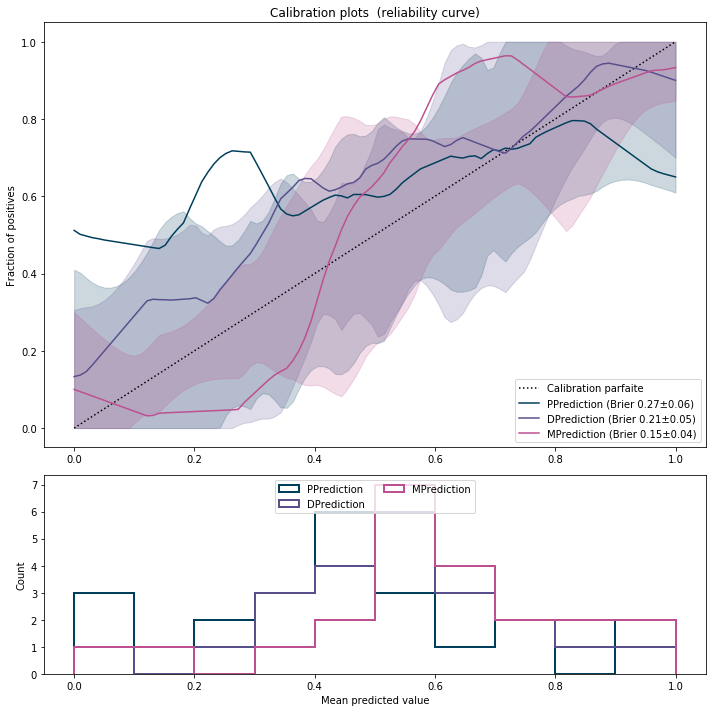

In [57]:
p_inputs['PPrediction_Prediction'] = p_inputs['Prediction_Prediction']
p_inputs['PPrediction_Probability'] = p_inputs['Prediction_Score']
p_inputs['DPrediction_Prediction'] = d_inputs['Prediction_Prediction']
p_inputs['DPrediction_Probability'] = d_inputs['Prediction_Score']
p_inputs['MPrediction_Prediction'] = m_inputs['Prediction_Prediction']
p_inputs['MPrediction_Probability'] = m_inputs['Prediction_Score']

figure = Views.reliability_curve(p_inputs, 'LesionEncode', ['PPrediction','DPrediction','MPrediction'])
figure.savefig(f'{prefix}.svg')
figure.show()

# Fusion

In [70]:
inputs = pandas.concat([p_inputs, d_inputs, m_inputs], axis=0)
inputs = inputs.reset_index(drop=True)
 # Save
IO.save(inputs, f'Low_{prefix}.pickle')

# Cumulative

In [71]:
inputs = IO.load(f'Low_{prefix}.pickle')

In [72]:
all_image = [True] * len(inputs.index)
single_image = inputs['Modality'] == 'Photography'
Data.build_bags(inputs, single_image, 'ID_Lesion', all_image, 'ID_Lesion', f'Prediction_{Tools.SCORE}')
inputs = inputs[single_image].reset_index(drop=True)

In [73]:
high_folds = Tools.generate_folds(([1], [2]), validation)
modality = MultimodalClassifier(method='modality', metric=f1_score)
modality_rev = MultimodalClassifier(method='modality', metric=f1_score, ordered=False)
classe = MultimodalClassifier(method='modality_class', metric=f1_score)
classe_rev = MultimodalClassifier(method='modality_class', metric=f1_score, ordered=False)

modality_ones = MultimodalClassifier(method='modality', metric=f1_score, from_zero=False)
modality_rev_ones = MultimodalClassifier(method='modality', metric=f1_score, ordered=False, from_zero=False)
classe_ones = MultimodalClassifier(method='modality_class', metric=f1_score, from_zero=False)
classe_rev_ones = MultimodalClassifier(method='modality_class', metric=f1_score, ordered=False, from_zero=False)

In [74]:
inputs[f'Prediction_{Tools.SCORE}']

0      [[0.3752563363330782, 0.6247436636669218], [0....
1      [[0.1148613251369176, 0.8851386748630824], [0....
2      [[0.3657730773101645, 0.6342269226898355], [0....
3      [[0.8406000287500424, 0.1593999712499577], [0....
4      [[1.0, 0.0], [1.0, 0.0], [0.7856379134790595, ...
                             ...                        
219    [[0.28589896864767295, 0.714101031352327], [0....
220    [[1.0, 0.0], [1.0, 0.0], [0.5084874138957494, ...
221    [[0.4713933587552164, 0.5286066412447836], [0....
222    [[0.3263392751776335, 0.6736607248223665], [0....
223    [[0.5062544367212034, 0.4937455632787966], [0....
Name: Prediction_Score, Length: 224, dtype: object

In [75]:
Tools.evaluate(inputs, {'datum': f'Prediction_{Tools.SCORE}', 'label_encode': 'LesionEncode'}, modality, 'simple_increase_increase')
Tools.evaluate(inputs, {'datum': f'Prediction_{Tools.SCORE}', 'label_encode': 'LesionEncode'}, modality_rev, 'simple_increase_decrease')
Tools.evaluate(inputs, {'datum': f'Prediction_{Tools.SCORE}', 'label_encode': 'LesionEncode'}, classe, 'double_increase_increase') 
Tools.evaluate(inputs, {'datum': f'Prediction_{Tools.SCORE}', 'label_encode': 'LesionEncode'}, classe_rev, 'double_increase_decrease')

Tools.evaluate(inputs, {'datum': f'Prediction_{Tools.SCORE}', 'label_encode': 'LesionEncode'}, modality_ones, 'simple_decrease_increase')
Tools.evaluate(inputs, {'datum': f'Prediction_{Tools.SCORE}', 'label_encode': 'LesionEncode'}, modality_rev_ones, 'simple_decrease_decrease')
Tools.evaluate(inputs, {'datum': f'Prediction_{Tools.SCORE}', 'label_encode': 'LesionEncode'}, classe_ones, 'double_decrease_increase') 
Tools.evaluate(inputs, {'datum': f'Prediction_{Tools.SCORE}', 'label_encode': 'LesionEncode'}, classe_rev_ones, 'double_decrease_decrease') 
IO.save(inputs, f'High_{prefix}.pickle')

# Score

,precision,recall,f1-score,support
Benign,0.63±0.20,0.78±0.16,0.70±0.12,86.00±2.29
Malignant,0.84±0.12,0.72±0.16,0.77±0.10,138.00±2.36
accuracy,0.74±0.10,0.74±0.10,0.74±0.10,0.74±0.10
macro avg,0.74±0.11,0.75±0.10,0.74±0.10,224.00±0.49
weighted avg,0.76±0.10,0.74±0.10,0.74±0.10,224.00±0.49


,precision,recall,f1-score,support
Benign,0.60±0.18,0.74±0.19,0.67±0.14,86.00±2.29
Malignant,0.81±0.13,0.70±0.14,0.75±0.10,138.00±2.36
accuracy,0.71±0.11,0.71±0.11,0.71±0.11,0.71±0.11
macro avg,0.71±0.11,0.72±0.12,0.71±0.11,224.00±0.49
weighted avg,0.73±0.11,0.71±0.11,0.72±0.10,224.00±0.49


,precision,recall,f1-score,support
Benign,0.59±0.32,0.22±0.18,0.32±0.21,86.00±2.29
Malignant,0.65±0.11,0.91±0.07,0.76±0.09,138.00±2.36
accuracy,0.64±0.12,0.64±0.12,0.64±0.12,0.64±0.12
macro avg,0.62±0.18,0.56±0.10,0.54±0.13,224.00±0.49
weighted avg,0.63±0.14,0.64±0.12,0.59±0.13,224.00±0.49


,precision,recall,f1-score,support
Benign,0.61±0.31,0.22±0.18,0.32±0.20,86.00±2.29
Malignant,0.65±0.12,0.91±0.07,0.76±0.09,138.00±2.36
accuracy,0.65±0.11,0.65±0.11,0.65±0.11,0.65±0.11
macro avg,0.63±0.18,0.57±0.10,0.54±0.13,224.00±0.49
weighted avg,0.64±0.14,0.65±0.11,0.59±0.13,224.00±0.49


,precision,recall,f1-score,support
Benign,0.70±0.20,0.83±0.17,0.76±0.11,86.00±2.29
Malignant,0.88±0.12,0.78±0.17,0.82±0.10,138.00±2.36
accuracy,0.79±0.10,0.79±0.10,0.79±0.10,0.79±0.10
macro avg,0.79±0.09,0.80±0.09,0.79±0.10,224.00±0.49
weighted avg,0.81±0.08,0.79±0.10,0.80±0.09,224.00±0.49


,precision,recall,f1-score,support
Benign,0.70±0.18,0.83±0.17,0.76±0.10,86.00±2.29
Malignant,0.88±0.12,0.78±0.16,0.82±0.09,138.00±2.36
accuracy,0.79±0.09,0.79±0.09,0.79±0.09,0.79±0.09
macro avg,0.79±0.09,0.80±0.08,0.79±0.09,224.00±0.49
weighted avg,0.81±0.07,0.79±0.09,0.80±0.08,224.00±0.49


,precision,recall,f1-score,support
Benign,0.86±0.13,0.66±0.18,0.75±0.09,86.00±2.29
Malignant,0.82±0.11,0.93±0.07,0.87±0.05,138.00±2.36
accuracy,0.83±0.06,0.83±0.06,0.83±0.06,0.83±0.06
macro avg,0.84±0.04,0.80±0.07,0.81±0.06,224.00±0.49
weighted avg,0.83±0.04,0.83±0.06,0.82±0.07,224.00±0.49


,precision,recall,f1-score,support
Benign,0.87±0.13,0.64±0.17,0.74±0.10,86.00±2.29
Malignant,0.81±0.10,0.94±0.06,0.87±0.05,138.00±2.36
accuracy,0.83±0.06,0.83±0.06,0.83±0.06,0.83±0.06
macro avg,0.84±0.05,0.79±0.07,0.80±0.07,224.00±0.49
weighted avg,0.83±0.05,0.83±0.06,0.82±0.07,224.00±0.49


,precision,recall,f1-score,support
Benign,0.63±0.32,0.22±0.18,0.33±0.21,86.00±2.29
Malignant,0.61±0.13,0.90±0.06,0.73±0.10,114.00±2.84
accuracy,0.61±0.12,0.61±0.12,0.61±0.12,0.61±0.12
macro avg,0.62±0.17,0.56±0.10,0.53±0.13,200.00±1.95
weighted avg,0.62±0.16,0.61±0.12,0.55±0.15,200.00±1.95


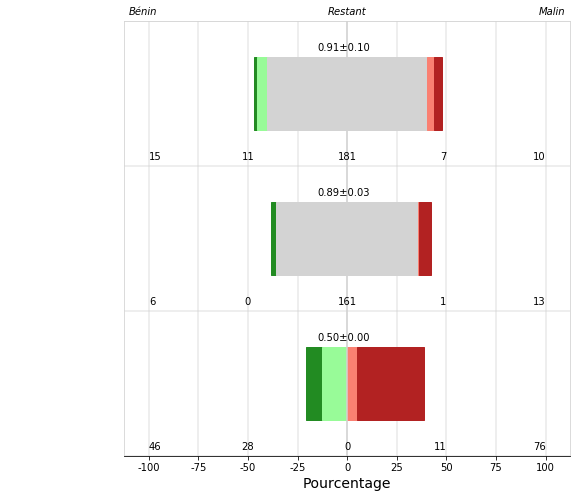

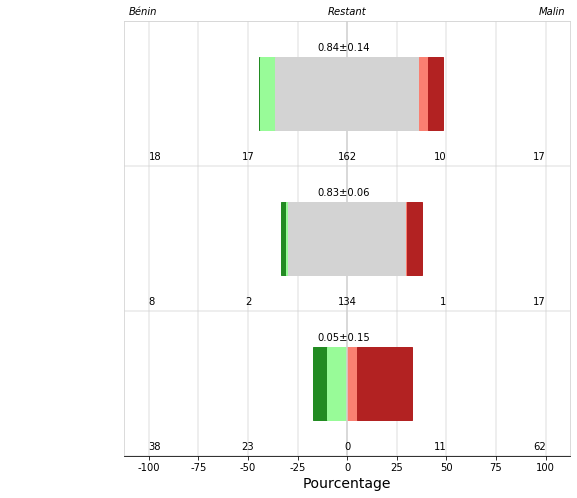

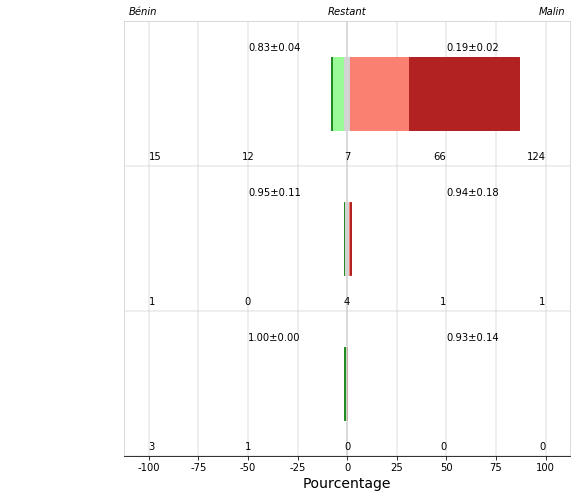

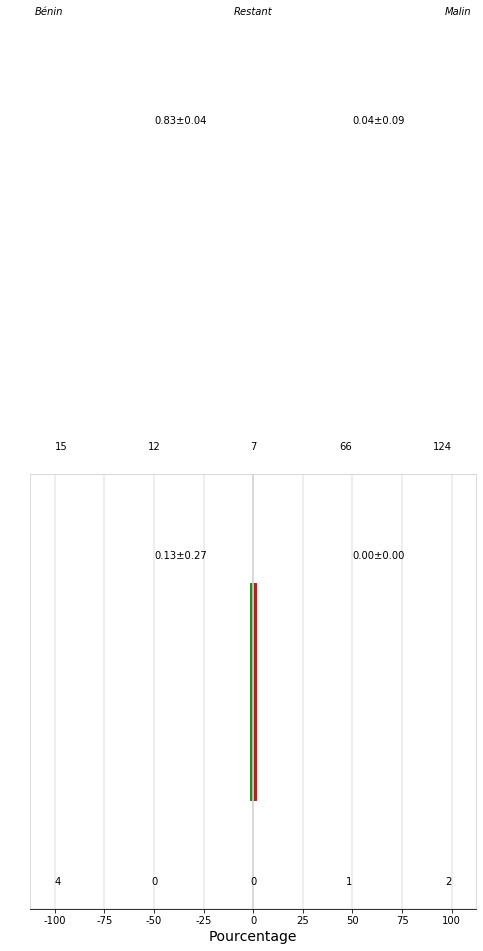

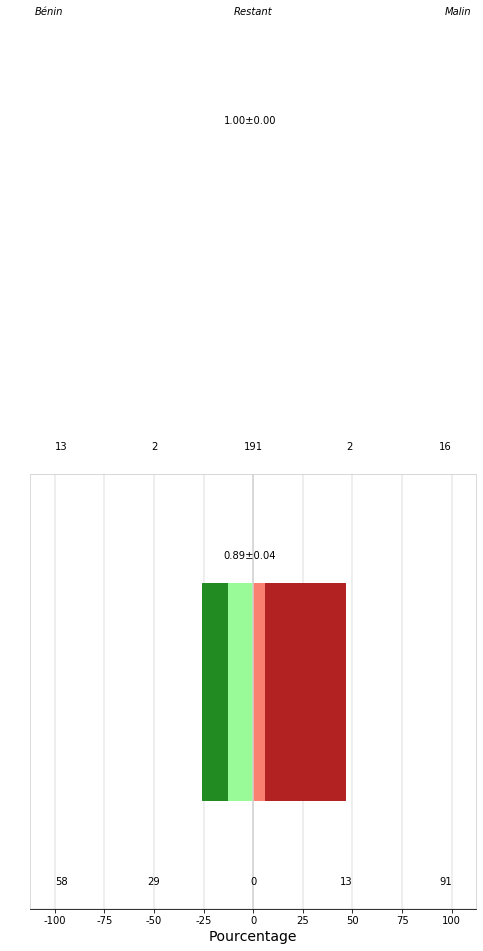

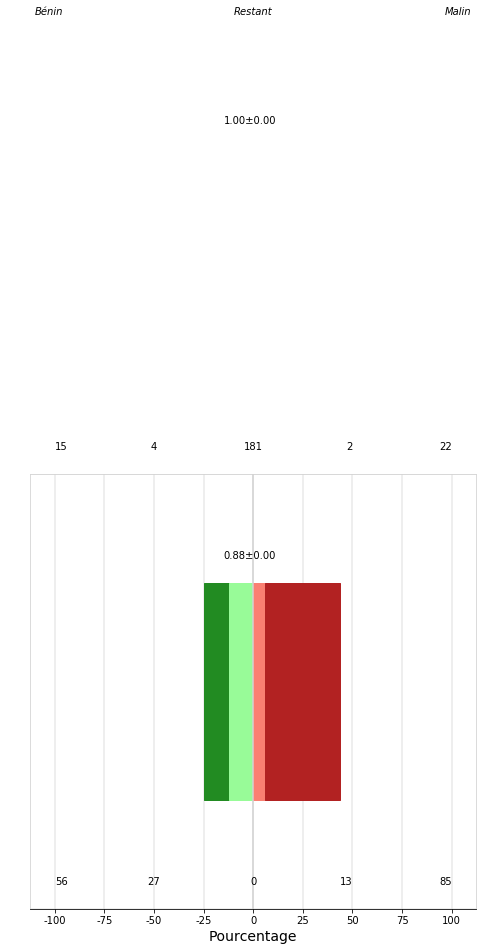

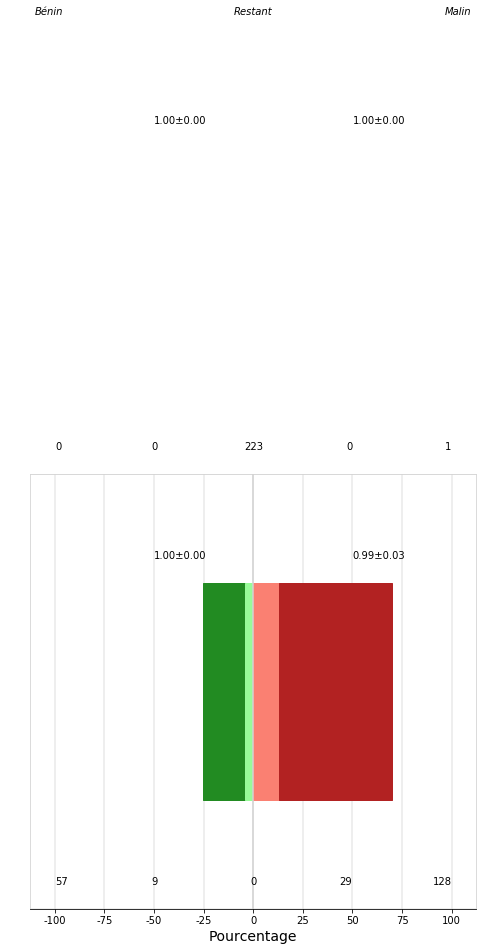

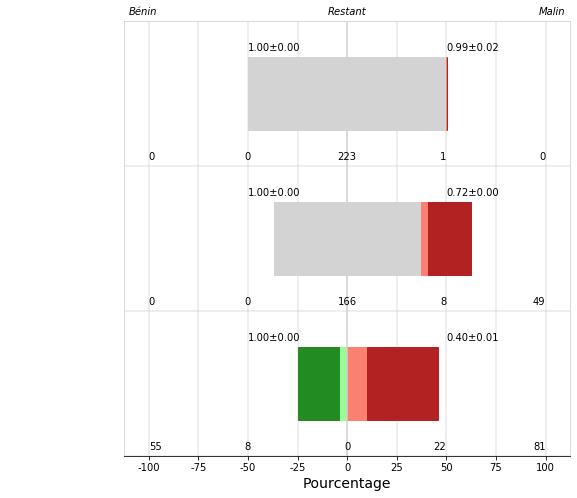

In [76]:
from IPython.display import HTML
from IPython.display import display

inputs = IO.load(f'High_{prefix}.pickle')
diagnosis_encoder = OrderedEncoder().fit(['Benign', 'Malignant'])

# ROC Curve
ViewsTools.plot_size((8,8))     

name = f'simple_increase_increase'
display(HTML(ViewsTools.dataframe_renderer([Views.report(inputs, {'label_encode': 'LesionEncode', 'eval': name}, diagnosis_encoder)],
                                                                    title=[f'Test - {name}'])))
figure = Views.steps_visualization(inputs, {'label_encode': 'LesionEncode', 'eval': name})
figure.savefig(f'{prefix}_{name}.svg')
figure.show()

name = f'simple_increase_decrease'
display(HTML(ViewsTools.dataframe_renderer([Views.report(inputs, {'label_encode': 'LesionEncode', 'eval': name}, diagnosis_encoder)],
                                                                    title=[f'Test - {name}'])))
figure = Views.steps_visualization(inputs, {'label_encode': 'LesionEncode', 'eval': name})
figure.savefig(f'{prefix}_{name}.svg')
figure.show()

name = f'double_increase_increase'
display(HTML(ViewsTools.dataframe_renderer([Views.report(inputs, {'label_encode': 'LesionEncode', 'eval': name}, diagnosis_encoder)],
                                                                        title=[f'Test - {name}'])))
figure = Views.steps_visualization(inputs, {'label_encode': 'LesionEncode', 'eval': name})
figure.savefig(f'{prefix}_{name}.svg')
figure.show()

name = f'double_increase_decrease'
display(HTML(ViewsTools.dataframe_renderer([Views.report(inputs, {'label_encode': 'LesionEncode', 'eval': name}, diagnosis_encoder)],
                                                                        title=[f'Test - {name}'])))
figure = Views.steps_visualization(inputs, {'label_encode': 'LesionEncode', 'eval': name})
figure.savefig(f'{prefix}_{name}.svg')
figure.show()

name = f'simple_decrease_increase'
display(HTML(ViewsTools.dataframe_renderer([Views.report(inputs, {'label_encode': 'LesionEncode', 'eval': name}, diagnosis_encoder)],
                                                                    title=[f'Test - {name}'])))
figure = Views.steps_visualization(inputs, {'label_encode': 'LesionEncode', 'eval': name})
figure.savefig(f'{prefix}_{name}.svg')
figure.show()

name = f'simple_decrease_decrease'
display(HTML(ViewsTools.dataframe_renderer([Views.report(inputs, {'label_encode': 'LesionEncode', 'eval': name}, diagnosis_encoder)],
                                                                    title=[f'Test - {name}'])))
figure = Views.steps_visualization(inputs, {'label_encode': 'LesionEncode', 'eval': name})
figure.savefig(f'{prefix}_{name}.svg')
figure.show()

name = f'double_decrease_increase'
display(HTML(ViewsTools.dataframe_renderer([Views.report(inputs, {'label_encode': 'LesionEncode', 'eval': name}, diagnosis_encoder)],
                                                                        title=[f'Test - {name}'])))
figure = Views.steps_visualization(inputs, {'label_encode': 'LesionEncode', 'eval': name})
figure.savefig(f'{prefix}_{name}.svg')
figure.show()

name = f'double_decrease_decrease'
display(HTML(ViewsTools.dataframe_renderer([Views.report(inputs, {'label_encode': 'LesionEncode', 'eval': name}, diagnosis_encoder)],
                                                                        title=[f'Test - {name}'])))
figure = Views.steps_visualization(inputs, {'label_encode': 'LesionEncode', 'eval': name})
figure.savefig(f'{prefix}_{name}.svg')
figure.show()

name = f'double_increase_decrease'
inputs_lm = inputs[(inputs['Diagnosis']=='LM/LMM')|(inputs['Binary_Diagnosis']=='Benign')]
display(HTML(ViewsTools.dataframe_renderer([Views.report(inputs_lm, {'label_encode': 'LesionEncode', 'eval': name}, diagnosis_encoder)],
                                                                        title=[f'Test - LM {name}'])))